## Imports

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx 

import folium
import json
import geopandas as gpd
from shapely.geometry import LineString
import json
import heapq
from collections import defaultdict, deque
import queue

import random
import os 

## Data

In [2]:
df_links = pd.read_csv("data/IC_NETWORK/df_links.csv") 
df_distances = pd.read_csv("data/distance_matrix.csv") 
df_od = pd.read_csv("data/od_df.csv") 

In [3]:

df_distances = df_distances.drop('Lugano Nord', axis=1)
# List of stations to remove
to_remove = ['Lugano Nord']

# Filter rows where 'Station_Name' is NOT in to_remove
df_distances = df_distances[~df_distances['Unnamed: 0'].isin(to_remove)]

# Optional: Reset index if needed
df_distances = df_distances.reset_index(drop=True)

In [4]:
map = df_distances.columns[1:].to_list()

df_od['org'] = df_od['org'].map(lambda x: map[x])
df_od['dest'] = df_od['dest'].map(lambda x: map[x])

### Data manipulation

To correctly model the network with transfers, we decided to model the transfers between lines at a station as seperate edges. By doing this we can have full control over transfer costs, line headways, ...

Each station - line pair is modeled as a seperate node in the network, to change lines at a node there is an additional edge to represent the transfer. 

### Modelling transfers

In [5]:
# Function to split multiple train lines and create individual connections
def process_multi_line_connections(df_links):

    """Expand rows with multiple train lines into individual connections"""
    
    rows = []
    
    for _, row in df_links.iterrows():
        # Check if there are multiple lines (comma-separated)
        if ',' in str(row['IC_lines']):
            # Split the lines and create a row for each line
            for line in [l.strip() for l in row['IC_lines'].split(',')]:
                new_row = row.copy()
                new_row['IC_lines'] = line
                rows.append(new_row)
        else:
            # Single line connection
            rows.append(row)

    df_expanded = pd.DataFrame(rows)
    
    return df_expanded

In [6]:
# Create bidirectional network with individual train lines
def create_bidirectional_network(df_expanded):
    
    # Create reversed connections for bidirectional network
    df_reversed = df_expanded.copy()
    df_reversed['start_node'], df_reversed['end_node'] = df_reversed['end_node'], df_reversed['start_node']
    
    # Combine original and reversed connections
    df_bidirectional = pd.concat([df_expanded, df_reversed], ignore_index=True)
    
    return df_bidirectional

In [7]:
# Add transfer edges between lines at the same station
def add_transfer_edges(df_bidirectional, transfer_time):
    
    """Add edges representing transfers between different lines at the same station"""
    
    # Get all unique station-line combinations
    station_lines = []
    for _, row in df_bidirectional.iterrows():
        station_lines.append((row['start_node'], row['IC_lines']))
    
    # Remove duplicates
    station_lines = list(set(station_lines))
    
    # Find stations with multiple lines
    stations = {}
    for station, line in station_lines:
        if station not in stations:
            stations[station] = []
        stations[station].append(line)
    
    # Create transfer edges
    transfer_edges = []
    
    for station, lines in stations.items():
        if len(lines) > 1:  # Only stations with multiple lines need transfers
            for i, line1 in enumerate(lines):
                for line2 in lines[i+1:]:
                    # Create bidirectional transfer edges
                    transfer_edges.append({
                        'start_node': station,
                        'end_node': station,
                        'distance [m]': 0,
                        'IC_lines': f"TRANSFER_{line1}_to_{line2}",
                        'transfer_time': transfer_time,
                        'is_transfer': True
                    })
                    transfer_edges.append({
                        'start_node': station,
                        'end_node': station,
                        'distance [m]': 0,
                        'IC_lines': f"TRANSFER_{line2}_to_{line1}",
                        'transfer_time': transfer_time,
                        'is_transfer': True
                    })
    
    # Convert to DataFrame
    transfer_df = pd.DataFrame(transfer_edges)
    
    # Add is_transfer column to original DataFrame
    df_bidirectional['is_transfer'] = False
    
    # Combine regular and transfer edges
    full_network = pd.concat([df_bidirectional, transfer_df], ignore_index=True)

    return full_network
    

In [8]:
# Create node-line pairs for modified Dijkstra
def create_node_line_pairs(network_df):
    
    """Create unique identifiers for each (station, line) combination"""
    
    # For regular edges: add source line and destination line
    network_df['source_line'] = network_df['IC_lines']
    
    # For transfer edges: extract source and destination lines
    transfer_mask = network_df['is_transfer']
    network_df.loc[transfer_mask, 'source_line'] = network_df.loc[transfer_mask, 'IC_lines'].apply(
        lambda x: x.split('_')[1]
    )
    network_df.loc[transfer_mask, 'dest_line'] = network_df.loc[transfer_mask, 'IC_lines'].apply(
        lambda x: x.split('_')[3]
    )
    
    # For regular edges: destination line is the same as source line
    network_df.loc[~transfer_mask, 'dest_line'] = network_df.loc[~transfer_mask, 'source_line']
    
    # Create node-line identifiers
    network_df['source_id'] = network_df['start_node'] + "_" + network_df['source_line']
    network_df['dest_id'] = network_df['end_node'] + "_" + network_df['dest_line']
    
    return network_df

In [9]:
# Calculate travel times on edges
def calculate_travel_times(network_df, speed_kmh=80):
    
    """Convert distances to travel times and add transfer penalties"""
    
    network_df['travel_time'] = np.where(
        network_df['is_transfer'],
        network_df['transfer_time'] + network_df['headway']/2,
        network_df['distance [m]'] / 1000 / speed_kmh * 60  + network_df['headway']/2 # Convert to minutes
    )
    
    return network_df

### Setting the headway, speed and capacity of the train lines

In [10]:
h30_line = ['IC3', 'IC5', 'IC6', 'IC61', 'IC81']
h60_line = ['IC1', 'IC2', 'IC8', 'IC21', 'IC51']

avg_capacity = 500
nb_train30 = 30
nb_train60 = 15

def add_capacity(row):
    if row['source_line'] != row['dest_line']:
        return np.inf
    if row['source_line'] == row['dest_line']and row['source_line'] in h30_line:
        return nb_train30 * avg_capacity
    if row['source_line'] == row['dest_line']and row['source_line'] in h60_line:
        return nb_train60 * avg_capacity
    
def add_headway(row):
    if row['source_line'] != row['dest_line']:
        if row['dest_line'] in h30_line:
            return 30
        else :
            return 60
    if row['source_line'] == row['dest_line']and row['source_line'] in h30_line:
        return 30
    if row['source_line'] == row['dest_line']and row['source_line'] in h60_line:
        return 60

In [11]:
H = 15 ## Here define the headway ---> we could make it more modulare and define a headway per line if wanted 
T = 5 ## Here define the transfer cost (5 mins to start)
V = 80 ## Here define the train speed 


df_expanded = process_multi_line_connections(df_links)
df_bidirectional = create_bidirectional_network(df_expanded)
full_network = add_transfer_edges(df_bidirectional, transfer_time=T)
full_network_with_names = create_node_line_pairs(full_network)

full_network_with_names['headway'] = full_network_with_names.apply(add_headway, axis=1)


df_network = calculate_travel_times(full_network_with_names, speed_kmh=V)    

df_network['capacity'] = df_network.apply(add_capacity, axis=1)
df_network.head(-10)

,start_node,end_node,distance [m],IC_lines,is_transfer,transfer_time,source_line,dest_line,source_id,dest_id,headway,travel_time,capacity
0,Zürich HB,Chur,116075.402,IC3,False,NaN,IC3,IC3,Zürich HB_IC3,Chur_IC3,30,102.056551,15000.0
1,Zürich HB,Winterthur,26787.367,IC5,False,NaN,IC5,IC5,Zürich HB_IC5,Winterthur_IC5,30,35.090525,15000.0
2,Zürich HB,Winterthur,26787.367,IC81,False,NaN,IC81,IC81,Zürich HB_IC81,Winterthur_IC81,30,35.090525,15000.0
3,Zürich HB,Baden,22587.175,IC3,False,NaN,IC3,IC3,Zürich HB_IC3,Baden_IC3,30,31.940381,15000.0
4,Zürich HB,Bern,120492.589,IC1,False,NaN,IC1,IC1,Zürich HB_IC1,Bern_IC1,60,120.369442,7500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Biel/Bienne,Biel/Bienne,0.000,TRANSFER_IC5_to_IC51,True,5.0,IC5,IC51,Biel/Bienne_IC5,Biel/Bienne_IC51,60,35.000000,inf
176,Lausanne,Lausanne,0.000,TRANSFER_IC5_to_IC1,True,5.0,IC5,IC1,Lausanne_IC5,Lausanne_IC1,60,35.000000,inf
177,Lausanne,Lausanne,0.000,TRANSFER_IC1_to_IC5,True,5.0,IC1,IC5,Lausanne_IC1,Lausanne_IC5,30,20.000000,inf
178,Olten,Olten,0.000,TRANSFER_IC5_to_IC6,True,5.0,IC5,IC6,Olten_IC5,Olten_IC6,30,20.000000,inf


In [12]:
df_network[df_network['start_node']== 'Lugano Nord']

,start_node,end_node,distance [m],IC_lines,is_transfer,transfer_time,source_line,dest_line,source_id,dest_id,headway,travel_time,capacity
24,Lugano Nord,Lugano,659.934,IC2,False,NaN,IC2,IC2,Lugano Nord_IC2,Lugano_IC2,60,30.494951,7500.0
25,Lugano Nord,Lugano,659.934,IC21,False,NaN,IC21,IC21,Lugano Nord_IC21,Lugano_IC21,60,30.494951,7500.0
26,Lugano Nord,Bellinzona,28895.062,IC2,False,NaN,IC2,IC2,Lugano Nord_IC2,Bellinzona_IC2,60,51.671296,7500.0
27,Lugano Nord,Bellinzona,28895.062,IC21,False,NaN,IC21,IC21,Lugano Nord_IC21,Bellinzona_IC21,60,51.671296,7500.0
150,Lugano Nord,Lugano Nord,0.000,TRANSFER_IC2_to_IC21,True,5.0,IC2,IC21,Lugano Nord_IC2,Lugano Nord_IC21,60,35.000000,inf
151,Lugano Nord,Lugano Nord,0.000,TRANSFER_IC21_to_IC2,True,5.0,IC21,IC2,Lugano Nord_IC21,Lugano Nord_IC2,60,35.000000,inf


### Let's now visualize the network

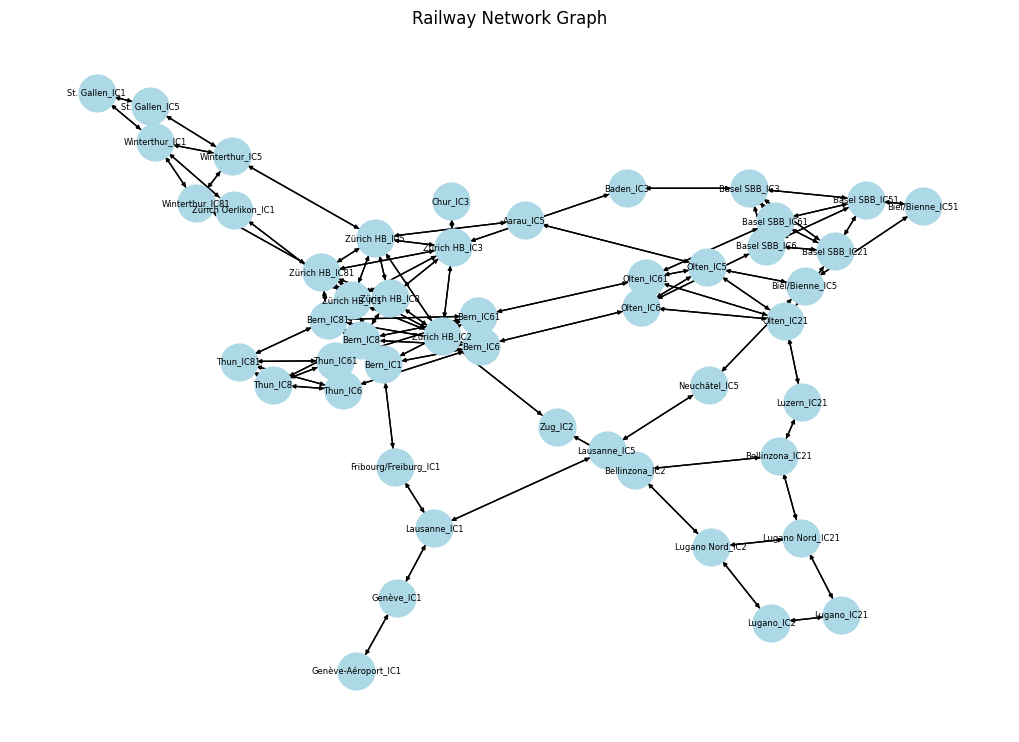

In [13]:
G = nx.DiGraph()

for _, row in df_network.iterrows():
    G.add_edge(row['source_id'], row['dest_id'], weight=row['travel_time'])

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42) 
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', arrowsize=6, font_size=6)
plt.title('Railway Network Graph')
plt.show()

## All or nothing assignment 

Since we have modeled our network with all these seperate nodes and edges to represent transfers, we can easily use the label correction algorithm used for standard traffic assignment 

However, to be able to give the algorithm just a city name and not a city_line combo, we had to do a quick manipulation 

In [14]:
def shortest_path_tree(df_node, df_link, t, org): 

    """
    Generate shortest path tree from a given origin node
    using label correction
    
    :param df_node, df_link: network data frames
    :param t: link cost
    :param org: origin node
    
    :return u: node label
    :return p: previous link on shortest path for each node
    """
    
    # define inputs
    n_node = len(df_node)

    r = int(org)

    outflow_link_frst = df_node.frst_out.values
    outflow_link_lst = df_node.lst_out.values

    start_node = df_link.start_node.values
    end_node = df_link.end_node.values


    # initialize
    u = np.inf * np.ones(n_node)
    u[r] = 0
    p = -1 * np.ones(n_node, dtype=int)
    Q = queue.Queue()
    Q.put(r) 

    while Q.qsize() > 0:

        node_i = Q.get()

        link_frst = outflow_link_frst[node_i]
        link_lst = outflow_link_lst[node_i]
        
        for link in range(link_frst, link_lst+1):
            node_j = end_node[link]
            if u[node_j] > u[node_i] + t[link]:
                u[node_j] = u[node_i] + t[link]
                p[node_j] = link  # instead of start node, assigning link here
                if node_j not in Q.queue:
                    Q.put(node_j)

    return u, p
    

In [15]:
def label_correction(t, r, n_node, outflow_link_frst, outflow_link_lst, end_node):
    
    """
    Generate shortest path tree from a given origin node using label correction

    :param t: link cost 
    :param r: origin node index
    :param n_node: number of nodes

    :param outflow_link_frst (outflow_link_lst): list of first (last) outflow link indices for each node
    :param end_node: list of end node indices for each link

    :return u: node label
    :return p: previous link on shortest path for each node
    """

    # initialize
    u = np.inf * np.ones(n_node)
    u[r] = 0
    p = -1 * np.ones(n_node, dtype=int)
    Q = queue.Queue()
    Q.put(r) 

    while Q.qsize() > 0 :

        node_i = Q.get() 

        link_frst = outflow_link_frst[node_i]
        link_lst = outflow_link_lst[node_i]
        
        for link in range(link_frst, link_lst + 1):

            node_j = end_node[link]

            if u[node_j] > u[node_i] + t[link] :

                u[node_j] = u[node_i] + t[link]
                p[node_j] = link
                Q.put(node_j)


    return u, p

In [16]:
def prepare_for_dijkstra(network_df):

    """Prepare network data for Dijkstra algorithm"""
    
    network_df = network_df.sort_values(['source_id', 'dest_id']).reset_index(drop=True)
    network_df['link_index'] = network_df.index

    grouped = network_df.groupby('source_id')['link_index'].agg(['min', 'max']).reset_index()

    node_df = pd.DataFrame({'node_id': grouped['source_id'],'frst_out': grouped['min'],'lst_out': grouped['max']})
    
    node_to_idx = {node: idx for idx, node in enumerate(node_df['node_id'])}
    end_node_indices = np.array([node_to_idx.get(node, -1) for node in network_df['dest_id']])
    

    # Create station to node mapping for flexible querying ---> so we can use just city names
    station_to_nodes = {}
    for node_id in node_df['node_id']:
        if '_' in node_id:
            station = node_id.split('_')[0]
            if station not in station_to_nodes:
                station_to_nodes[station] = []
            station_to_nodes[station].append(node_id)
    
    return node_df, node_to_idx, end_node_indices, network_df, station_to_nodes

In [17]:
def get_origin_nodes(origin_input, node_to_idx, station_to_nodes):

    """
    Get origin node indices based on input (can be station name or full node ID)
    Returns list of node indices
    """
    
    # Check if it's a full node ID
    if origin_input in node_to_idx:
        return [node_to_idx[origin_input]]
    
    # Check if it's a station name
    if origin_input in station_to_nodes:
        return [node_to_idx[node_id] for node_id in station_to_nodes[origin_input]]
    
    # If neither found, raise error
    raise ValueError(f"Origin '{origin_input}' not found in network")

In [18]:
node_df, node_to_idx, end_node_indices, network_df_sorted, station_to_nodes = prepare_for_dijkstra(df_network)

n_node = len(node_df)
outflow_link_frst = node_df['frst_out'].values
outflow_link_lst = node_df['lst_out'].values
link_costs = network_df_sorted['travel_time'].values


origin_input = "Lausanne"

origin_indices = get_origin_nodes(origin_input, node_to_idx, station_to_nodes)


# Multiple origin nodes - run algorithm from each and combine results
best_u = np.inf * np.ones(n_node)
best_p = -1 * np.ones(n_node, dtype=int)

for origin_idx in origin_indices:
    u, p = label_correction(link_costs, origin_idx, n_node, outflow_link_frst, outflow_link_lst, end_node_indices)
    
    # Update best paths
    for i in range(n_node):
        if u[i] < best_u[i]:
            best_u[i] = u[i]
            best_p[i] = p[i]

In [19]:
best_u

array([193.29906675, 291.35912675, 262.6483115 , 248.10605125,
       228.10605125, 232.6483115 , 232.6483115 , 467.494849  ,
       432.494849  , 132.66618375, 152.66618375, 152.66618375,
       167.66618375, 152.66618375, 108.21605775, 143.21605775,
       361.475297  ,  79.3337625 , 109.6086135 ,  75.1699725 ,
         0.        ,   0.        , 519.1661455 , 484.1661455 ,
       549.661096  , 514.661096  , 275.0950835 ,  71.31596775,
       203.26901375, 168.26901375, 188.26901375, 188.26901375,
       367.36355225, 332.36355225, 191.11419275, 191.11419275,
       221.11419275, 191.11419275, 309.50927075, 274.50927075,
       293.12615075, 326.116019  , 253.0356255 , 274.4187455 ,
       259.4187455 , 239.4187455 , 274.4187455 , 258.0356255 ,
       287.06193825])

In [20]:
best_p

array([100, 161,  95,  15,  68, 105, 110,  32,  91,  71,  35,  36,  37,
        38,  93,  65, 162,  76,  74,  77,  -1,  -1,  30,  33,  83,  86,
        96,  80, 102,  67, 103, 104, 117, 139,  46,  52,  57,  63, 140,
       169, 182, 155,  40, 171, 172,   1, 173,  64, 154])

In [21]:
unreachable_indices = np.where(best_p == -1)[0]
print("Unreachable nodes:")
for idx in unreachable_indices:
    print(f"Index {idx}: {node_df.iloc[idx]['node_id']}")

Unreachable nodes:
Index 20: Lausanne_IC1
Index 21: Lausanne_IC5


In [22]:
def all_or_nothing_assignment(df_od, node_df, network_df_sorted, node_to_idx, station_to_nodes, t):
    """
    Debug version of all-or-nothing assignment with detailed logging
    """
    
    # Initialize link flows
    n_link = len(network_df_sorted)
    x = np.zeros(n_link)
    
    # Debug counters
    total_demand_processed = 0
    missing_origins = 0
    missing_destinations = 0
    successful_assignments = 0
    
    # Get network parameters
    n_node = len(node_df)
    outflow_link_frst = node_df['frst_out'].values
    outflow_link_lst = node_df['lst_out'].values
    end_node_indices = np.array([node_to_idx.get(node, -1) for node in network_df_sorted['dest_id']])
    
    # Get unique origins from OD matrix
    unique_origins = np.unique(df_od['org'].values)
    print(f"Processing {len(unique_origins)} unique origins")
    print(f"Sample origins: {list(unique_origins[:5])}")
    
    for i, origin_station in enumerate(unique_origins):
        if i % 5 == 0:  # Progress indicator
            print(f"Processing origin {i+1}/{len(unique_origins)}: {origin_station}")
        
        # Get origin node indices
        if origin_station in station_to_nodes:
            origin_indices = [node_to_idx[node_id] for node_id in station_to_nodes[origin_station]]
        elif origin_station in node_to_idx:
            origin_indices = [node_to_idx[origin_station]]
        else:
            print(f"ERROR: Origin {origin_station} not found in network")
            missing_origins += 1
            continue
        
        # Run shortest path from all nodes at this station
        best_u = np.inf * np.ones(n_node)
        best_p = -1 * np.ones(n_node, dtype=int)
        
        for origin_idx in origin_indices:
            u, p = label_correction(t, origin_idx, n_node, outflow_link_frst, outflow_link_lst, end_node_indices)
            
            # Update best paths
            for j in range(n_node):
                if u[j] < best_u[j]:
                    best_u[j] = u[j]
                    best_p[j] = p[j]
        
        # Get OD pairs for this origin
        origin_ods = df_od[df_od['org'] == origin_station]
        
        for _, od_row in origin_ods.iterrows():
            dest_station = od_row['dest']
            demand = od_row['q']
            total_demand_processed += demand
            
            # Get destination node index
            if dest_station in station_to_nodes:
                dest_node_id = station_to_nodes[dest_station][0]
                dest_idx = node_to_idx[dest_node_id]
            elif dest_station in node_to_idx:
                dest_idx = node_to_idx[dest_station]
            else:
                print(f"ERROR: Destination {dest_station} not found in network")
                missing_destinations += 1
                continue
            
            # Check if destination is reachable
            if best_u[dest_idx] == np.inf:
                print(f"ERROR: {dest_station} unreachable from {origin_station}")
                continue
            
            # Trace back shortest path and assign flow
            current_node = dest_idx
            path_length = 0
            max_path_length = n_node
            links_in_path = []
            
            while best_p[current_node] != -1 and path_length < max_path_length:
                link_idx = best_p[current_node]
                links_in_path.append(link_idx)
                x[link_idx] += demand
                
                # Move to previous node
                source_node_id = network_df_sorted.iloc[link_idx]['source_id']
                current_node = node_to_idx[source_node_id]
                path_length += 1
            
            if path_length >= max_path_length:
                print(f"ERROR: Infinite loop for {origin_station} -> {dest_station}")
            else:
                successful_assignments += 1
                
            # Debug first few assignments
            if successful_assignments <= 3:
                print(f"  OD: {origin_station} -> {dest_station}, demand: {demand}, path length: {path_length}")
    
    print(f"\n=== SUMMARY ===")
    print(f"Total demand in OD matrix: {df_od['q'].sum()}")
    print(f"Total demand processed: {total_demand_processed}")
    print(f"Missing origins: {missing_origins}")
    print(f"Missing destinations: {missing_destinations}")
    print(f"Successful assignments: {successful_assignments}")
    print(f"Total assigned flow: {x.sum()}")
    print(f"Links with zero flow: {np.sum(x == 0)}/{len(x)}")
    print(f"Links with positive flow: {np.sum(x > 0)}/{len(x)}")
    
    return x

# Run the debug version
x_debug = all_or_nothing_assignment(df_od, node_df, network_df_sorted, node_to_idx, station_to_nodes, link_costs)

Processing 21 unique origins
Sample origins: ['Aarau', 'Baden', 'Basel SBB', 'Bellinzona', 'Bern']
Processing origin 1/21: Aarau
  OD: Aarau -> Bern, demand: 2758.0, path length: 4
  OD: Aarau -> Basel SBB, demand: 11851.0, path length: 3
  OD: Aarau -> Lausanne, demand: 6738.0, path length: 5
Processing origin 6/21: Biel/Bienne
Processing origin 11/21: Lausanne
Processing origin 16/21: St. Gallen
Processing origin 21/21: Zürich Oerlikon

=== SUMMARY ===
Total demand in OD matrix: 2338598.0
Total demand processed: 2338598.0
Missing origins: 0
Missing destinations: 0
Successful assignments: 420
Total assigned flow: 9708609.0
Links with zero flow: 85/190
Links with positive flow: 105/190


In [23]:
# total_demand = df_od['q'].sum()
# total_assigned = x.sum()
# print(f"Total demand: {total_demand}")
# print(f"Total assigned: {total_assigned}")

## Frank- Wolf

In [24]:
def objective(x, t):
    t = x*t
    obj = sum(t)
    return obj

In [25]:
def line_search(network_df_sorted, x, y, max_gap):
    """
    Determine step size by bisection line search

    :param df_link: link data frame
    :param x: current link flows
    :param y: target link flows
    :param max_gap: gap threshold
    :return step: optimal step size
    """

    # initialize 
    lb = 0
    ub = 1
    step = 0.5
    z = x + step * (y - x)
    t = link_cost_function(network_df_sorted, z)
    diff = np.dot(t, y - x)

    # main loop
    while ub - lb > max_gap or diff > 0:
        # update bounds based on boundary value difference
        if diff < 0:
            lb = step
        else:
            ub = step

        step = 0.5 * (lb + ub)
        z = x + step * (y - x)
        t = link_cost_function(network_df_sorted, z)
        diff = np.dot(t, y - x)


    return step

In [26]:
def static_assignment_fw(df_od, df_node, network_df_sorted, max_iter, max_gap, max_gap_ls):
    
    """
    Solve static traffic assignment 
    using Frank-Wolfe algorithm

    :param df_od, df_node, df_link: network data frames
    :param max_iter: max number of iterations of main loop
    :param max_gap: gap threshold of main loop
    :param max_gap_ls: gap threshold of line search
    :return x_star: equilibrium link flow
    :return gap: gap over iterations
    :return obj: objective value over iterations
    """

    # initialize link flow 
    n_link = len(network_df_sorted)
    x = np.zeros(n_link)
    t = link_cost_function(network_df_sorted, x)
    x = all_or_nothing_assignment(df_od, df_node, network_df_sorted, node_to_idx, station_to_nodes, t)

    # main loop 
    gap = np.inf * np.ones(max_iter)
    obj = np.inf * np.ones(max_iter)
    i = 0

    for i in range(max_iter):
        # update link travel time
        t = link_cost_function(network_df_sorted, x)

        # solve target flow
        y = all_or_nothing_assignment(df_od, df_node, network_df_sorted, node_to_idx, station_to_nodes, t)

        # derive step size by line search
        step = line_search(network_df_sorted, x, y, max_gap_ls)

        # compute relative gap
        gap[i] = np.dot(t, x-y)/np.dot(t, x)

        # update link flow
        x += step * (y - x)

        # compute objective value
        obj[i] = objective(x, t)

        # check convergence 
        if gap[i] < max_gap:
            break

    # process outputs
    x_star = x
    gap = gap[:i+1]
    obj = obj[:i+1]

    return x_star, gap, obj

## Linear Link Cost 

In [27]:
max_iter = 100
max_gap = 1e-4
max_gap_ls = 1e-2

In [28]:
def link_cost_function(network_df_sorted, x):
    cap = network_df_sorted['capacity'].values
    travel_time = network_df_sorted['travel_time'].values
    
    d = x / cap
    
    crowding_multiplier = 1 + 0.25 * d
    
    t = travel_time * crowding_multiplier
    
    return t

In [29]:
x, gap, obj = static_assignment_fw(df_od, node_df, network_df_sorted, max_iter, max_gap, max_gap_ls)

Processing 21 unique origins
Sample origins: ['Aarau', 'Baden', 'Basel SBB', 'Bellinzona', 'Bern']
Processing origin 1/21: Aarau
  OD: Aarau -> Bern, demand: 2758.0, path length: 4
  OD: Aarau -> Basel SBB, demand: 11851.0, path length: 3
  OD: Aarau -> Lausanne, demand: 6738.0, path length: 5
Processing origin 6/21: Biel/Bienne
Processing origin 11/21: Lausanne
Processing origin 16/21: St. Gallen
Processing origin 21/21: Zürich Oerlikon

=== SUMMARY ===
Total demand in OD matrix: 2338598.0
Total demand processed: 2338598.0
Missing origins: 0
Missing destinations: 0
Successful assignments: 420
Total assigned flow: 9708609.0
Links with zero flow: 85/190
Links with positive flow: 105/190
Processing 21 unique origins
Sample origins: ['Aarau', 'Baden', 'Basel SBB', 'Bellinzona', 'Bern']
Processing origin 1/21: Aarau
  OD: Aarau -> Bern, demand: 2758.0, path length: 4
  OD: Aarau -> Basel SBB, demand: 11851.0, path length: 4
  OD: Aarau -> Lausanne, demand: 6738.0, path length: 6
Processing

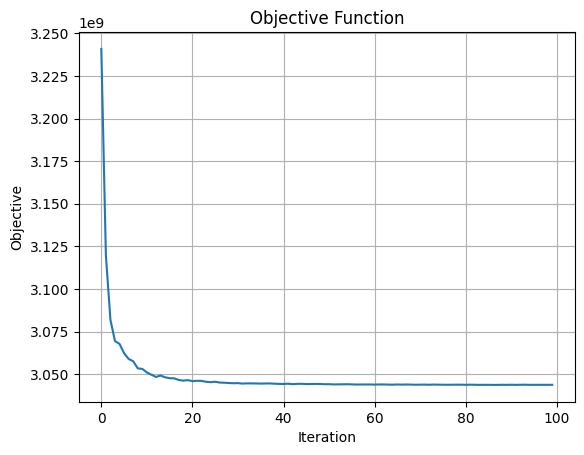

In [30]:
plt.figure()
plt.plot(obj)
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.title('Objective Function')
plt.grid()

In [31]:
zero_indices = np.where(x == 0.0)[0]  # [0] perché np.where restituisce una tupla
print("Indici degli zeri:", zero_indices)
zero_flow_link = network_df_sorted.loc[zero_indices]
#zero_flow_link

Indici degli zeri: [  4   5   6   7  16  21  22  27  42  43  48  56  61  62  82  85  88 109
 114 115 120 121 122 125 126 129 130 133 134 136]


In [32]:
final_link_cost = link_cost_function(network_df_sorted, x)

In [33]:
network_df_sorted['link_flow'] = x
network_df_sorted['link_cost'] = final_link_cost

In [34]:
transfer_link = network_df_sorted[network_df_sorted['is_transfer']== True]
transfer_link = transfer_link[~transfer_link['start_node'].isin(to_remove)]

line_link = network_df_sorted[network_df_sorted['is_transfer']== False]

In [35]:
line_grouped = line_link.groupby(by='IC_lines').sum()
transfer_grouped = transfer_link.groupby(by='start_node').sum()

In [36]:
line_flow_sorted = line_link.sort_values(by='link_flow', ascending=False)
line_flow_sorted.head()

,start_node,end_node,distance [m],IC_lines,is_transfer,transfer_time,source_line,dest_line,source_id,dest_id,headway,travel_time,capacity,link_index,link_flow,link_cost
92,Luzern,Olten,55768.093,IC21,False,NaN,IC21,IC21,Luzern_IC21,Olten_IC21,60,71.826070,7500.0,92,514365.691481,1303.321604
96,Olten,Luzern,55768.093,IC21,False,NaN,IC21,IC21,Olten_IC21,Luzern_IC21,60,71.826070,7500.0,96,368674.205025,954.506709
147,Zug,Zürich HB,28929.698,IC2,False,NaN,IC2,IC2,Zug_IC2,Zürich HB_IC2,60,51.697274,7500.0,147,295942.183499,561.677407
155,Zürich HB,Zug,28929.698,IC2,False,NaN,IC2,IC2,Zürich HB_IC2,Zug_IC2,60,51.697274,7500.0,155,271158.669954,518.969404
100,Olten,Aarau,13373.404,IC5,False,NaN,IC5,IC5,Olten_IC5,Aarau_IC5,30,25.030053,15000.0,100,270484.453059,137.867390


#### Plot

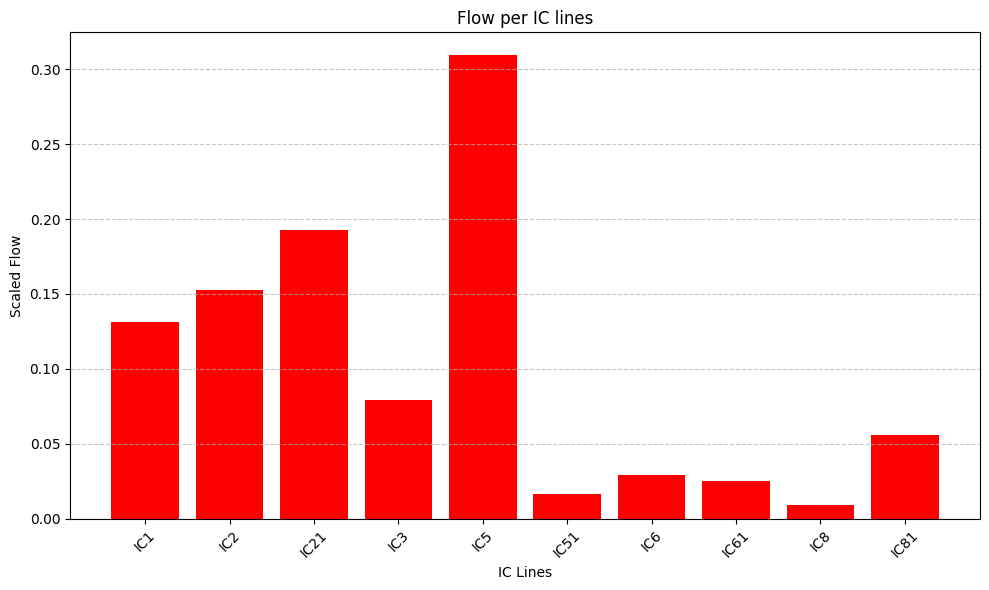

In [ ]:
import matplotlib.pyplot as plt

# Extract data
lines = line_grouped.index  # IC line names (e.g., 'IC1', 'IC2')
total_flow = line_grouped['link_flow'].sum()
flows = line_grouped['link_flow'].values/total_flow  # Flow values


# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(lines, flows, color='red')
plt.xlabel('IC Lines')
plt.ylabel('Scaled Flow')
plt.title('Flow per IC lines')
plt.xticks(rotation=45)  # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.savefig('flow_ic.png')
plt.show()

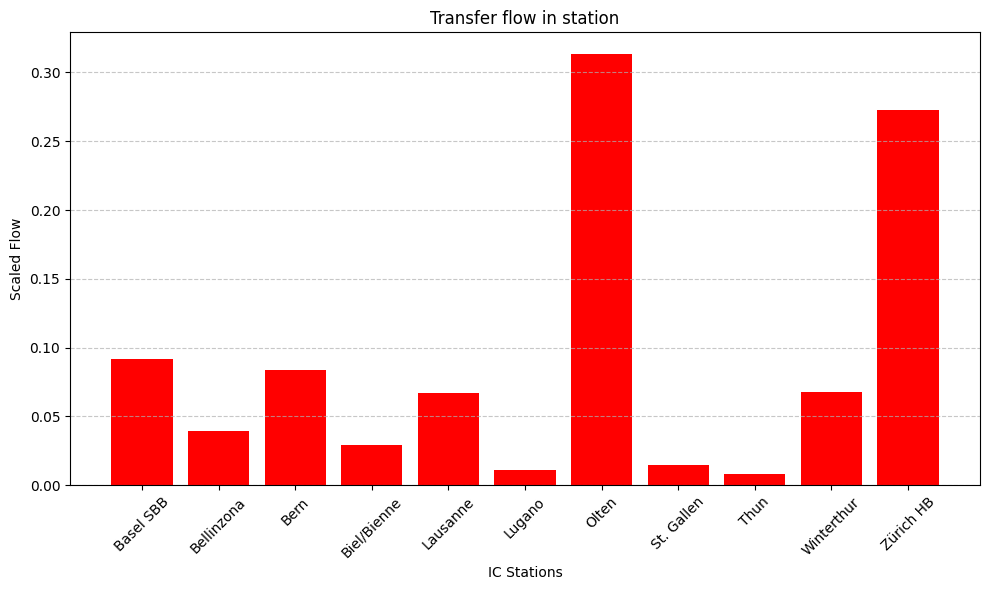

In [ ]:
# Extract data
lines = transfer_grouped.index
total_flow = transfer_grouped['link_flow'].sum()
flows = transfer_grouped['link_flow'].values/total_flow  # Flow values


# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(lines, flows, color='red')
plt.xlabel('IC Stations')
plt.ylabel('Scaled Flow')
plt.title('Transfer flow in station')
plt.xticks(rotation=45)  # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.savefig('transfer.png')
plt.show()

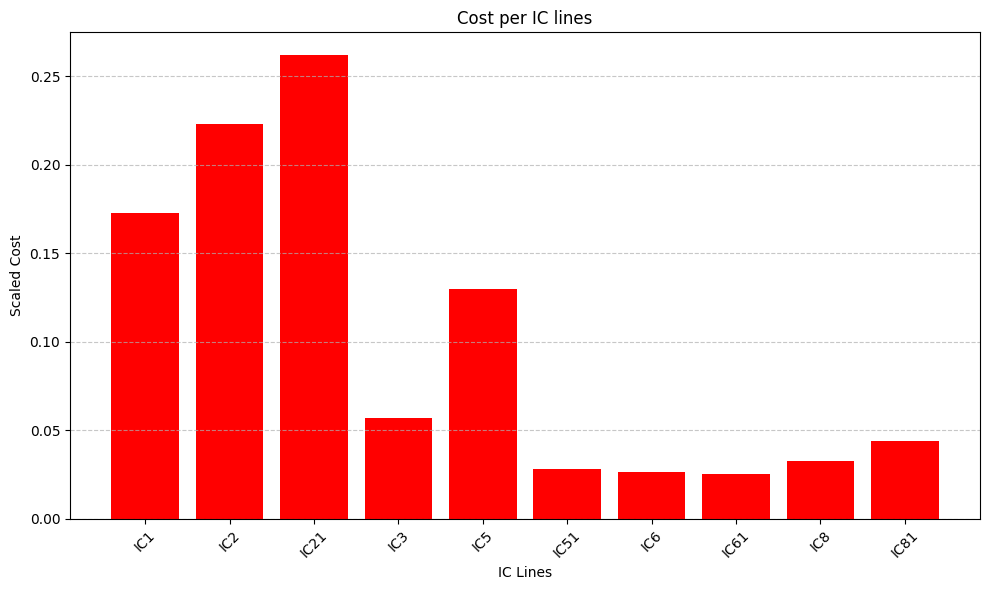

In [ ]:
# Extract data
lines = line_grouped.index  
total_cost = line_grouped['link_cost'].sum()
cost = line_grouped['link_cost'].values/total_cost # Flow values


# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(lines, cost, color='red')
plt.xlabel('IC Lines')
plt.ylabel('Scaled Cost')
plt.title('Cost per IC lines')
plt.xticks(rotation=45)  # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.savefig('cost.png')
plt.show()

## Quadratic Link Cost

In [40]:
def link_cost_function(network_df_sorted, x):

    cap = network_df_sorted['capacity'].values

    travel_time = network_df_sorted['travel_time'].values
    crowdness_cost = 0.25*(x/cap)**3

    t = travel_time + crowdness_cost

    return t

In [41]:
def link_cost_function(network_df_sorted, x):
    cap = network_df_sorted['capacity'].values
    travel_time = network_df_sorted['travel_time'].values
    
    d = x / cap
    
    crowding_multiplier = 1 + 0.25 * d **3
    
    t = travel_time * crowding_multiplier
    
    return t

In [42]:
x, gap, obj = static_assignment_fw(df_od, node_df, network_df_sorted, max_iter, max_gap, max_gap_ls)

Processing 21 unique origins
Sample origins: ['Aarau', 'Baden', 'Basel SBB', 'Bellinzona', 'Bern']
Processing origin 1/21: Aarau
  OD: Aarau -> Bern, demand: 2758.0, path length: 4
  OD: Aarau -> Basel SBB, demand: 11851.0, path length: 3
  OD: Aarau -> Lausanne, demand: 6738.0, path length: 5
Processing origin 6/21: Biel/Bienne
Processing origin 11/21: Lausanne
Processing origin 16/21: St. Gallen
Processing origin 21/21: Zürich Oerlikon

=== SUMMARY ===
Total demand in OD matrix: 2338598.0
Total demand processed: 2338598.0
Missing origins: 0
Missing destinations: 0
Successful assignments: 420
Total assigned flow: 9708609.0
Links with zero flow: 85/190
Links with positive flow: 105/190
Processing 21 unique origins
Sample origins: ['Aarau', 'Baden', 'Basel SBB', 'Bellinzona', 'Bern']
Processing origin 1/21: Aarau
  OD: Aarau -> Bern, demand: 2758.0, path length: 4
  OD: Aarau -> Basel SBB, demand: 11851.0, path length: 4
  OD: Aarau -> Lausanne, demand: 6738.0, path length: 9
Processing

In [43]:
zero_indices = np.where(x == 0.0)[0]  # [0] perché np.where restituisce una tupla
print("Indici degli zeri:", zero_indices)
zero_flow_link = network_df_sorted.loc[zero_indices]
#zero_flow_link

Indici degli zeri: [  6   7  22  27  42  56  62  82  85  88 115 120 121 122 125 126 129 130
 133 134]


In [44]:
final_link_cost = link_cost_function(network_df_sorted, x)

In [45]:
network_df_sorted['link_flow'] = x
network_df_sorted['link_cost'] = final_link_cost

In [46]:
transfer_link = network_df_sorted[network_df_sorted['is_transfer']== True]
transfer_link = transfer_link[~transfer_link['start_node'].isin(to_remove)]

line_link = network_df_sorted[network_df_sorted['is_transfer']== False]

In [47]:
line_grouped = line_link.groupby(by='IC_lines').sum()
transfer_grouped = transfer_link.groupby(by='start_node').sum()

In [48]:
line_flow_sorted = line_link.sort_values(by='link_flow', ascending=False)
line_flow_sorted.head()

,start_node,end_node,distance [m],IC_lines,is_transfer,transfer_time,source_line,dest_line,source_id,dest_id,headway,travel_time,capacity,link_index,link_flow,link_cost
92,Luzern,Olten,55768.093,IC21,False,NaN,IC21,IC21,Luzern_IC21,Olten_IC21,60,71.826070,7500.0,92,430739.006171,3.401654e+06
96,Olten,Luzern,55768.093,IC21,False,NaN,IC21,IC21,Olten_IC21,Luzern_IC21,60,71.826070,7500.0,96,310894.631213,1.279094e+06
147,Zug,Zürich HB,28929.698,IC2,False,NaN,IC2,IC2,Zug_IC2,Zürich HB_IC2,60,51.697274,7500.0,147,308716.946175,9.014262e+05
31,Bellinzona,Zug,193790.225,IC2,False,NaN,IC2,IC2,Bellinzona_IC2,Zug_IC2,60,175.342669,7500.0,31,295846.993829,2.690752e+06
155,Zürich HB,Zug,28929.698,IC2,False,NaN,IC2,IC2,Zürich HB_IC2,Zug_IC2,60,51.697274,7500.0,155,258086.321134,5.266977e+05


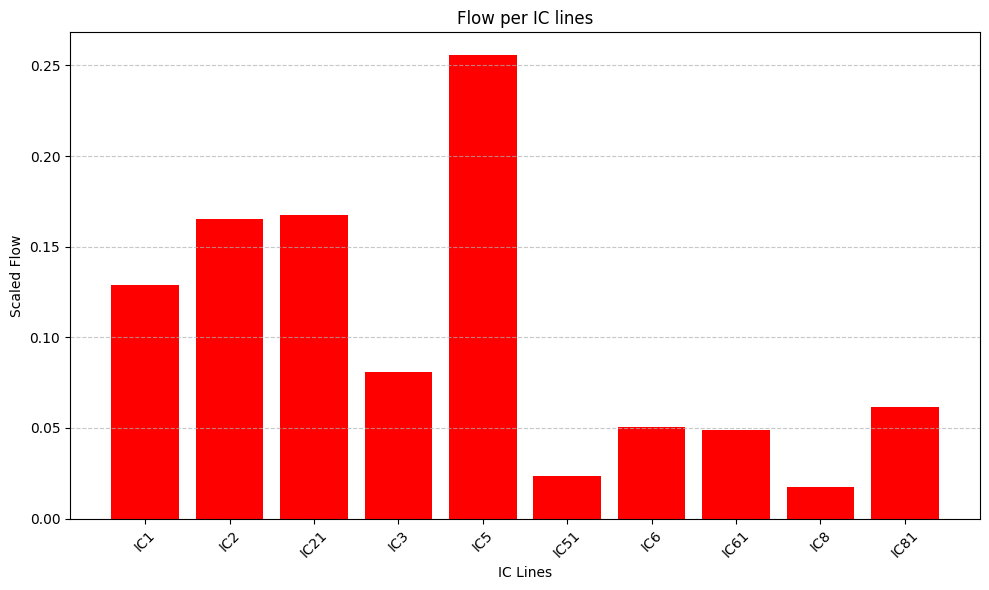

In [49]:
# Extract data
lines = line_grouped.index  # IC line names (e.g., 'IC1', 'IC2')
total_flow = line_grouped['link_flow'].sum()
flows = line_grouped['link_flow'].values/total_flow  # Flow values


# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(lines, flows, color='red')
plt.xlabel('IC Lines')
plt.ylabel('Scaled Flow')
plt.title('Flow per IC lines')
plt.xticks(rotation=45)  # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

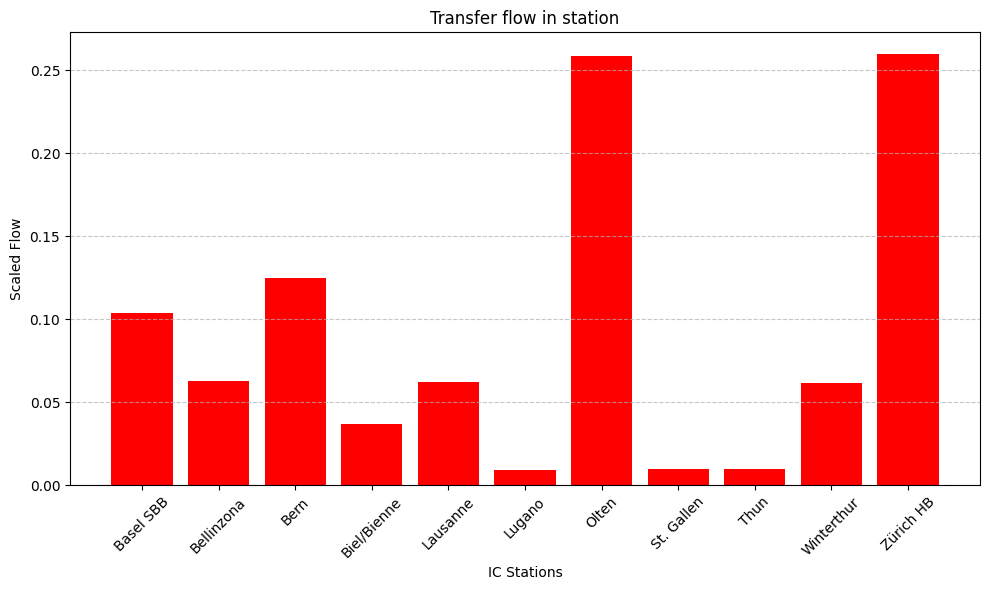

In [50]:
# Extract data
lines = transfer_grouped.index
total_flow = transfer_grouped['link_flow'].sum()
flows = transfer_grouped['link_flow'].values/total_flow  # Flow values


# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(lines, flows, color='red')
plt.xlabel('IC Stations')
plt.ylabel('Scaled Flow')
plt.title('Transfer flow in station')
plt.xticks(rotation=45)  # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

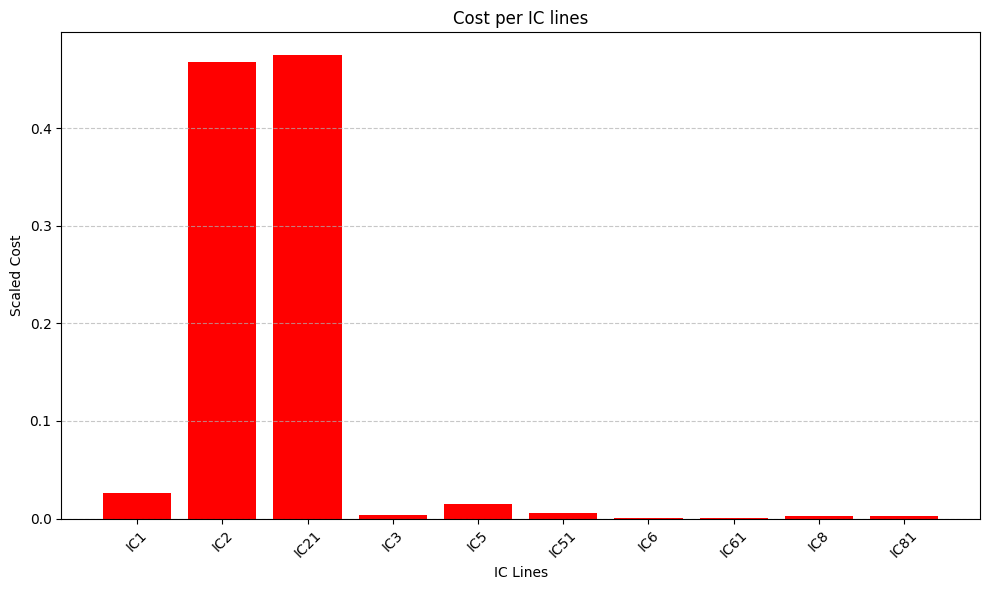

In [51]:
# Extract data
lines = line_grouped.index  
total_cost = line_grouped['link_cost'].sum()
cost = line_grouped['link_cost'].values/total_cost # Flow values


# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(lines, cost, color='red')
plt.xlabel('IC Lines')
plt.ylabel('Scaled Cost')
plt.title('Cost per IC lines')
plt.xticks(rotation=45)  # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()